In [107]:
import pandas as pd, os, csv, preprocessing, datetime as dt, matplotlib.pyplot as plt, numpy as np, seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull


# Read in Large Text File

In [2]:
iter_csv = pd.read_csv('../data/itcont.txt', iterator=True, chunksize=100000, header=None, 
                       error_bad_lines=False, sep='|', parse_dates=[13])
df = pd.concat([chunk[chunk[3] == 'P2020'].iloc[:,:-6] for chunk in iter_csv])
headers = pd.read_csv('../data/indiv_header_file.csv')
df.columns = headers.iloc[:,:-6].columns

/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (10,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (5,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (10,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-package

## Creating Maps bc FEC data is organized like shit
The individual contribution dataset contains only reference to committees. These maps help connect committees to candidates

In [3]:
cand_id_to_name = {}
committee_to_cand = {}
with open('../data/cn.txt') as csvfile:
    data = csv.reader(csvfile, delimiter='|')
    for row in data:
        cand_id_to_name[row[0]] = row[1]
        
with open('../data/ccl.txt') as csvfile:
    data = csv.reader(csvfile, delimiter='|')
    for row in data:
        committee_to_cand[row[3]] = cand_id_to_name.get(row[0], 'unknown')

In [4]:
df['cand_nm'] = df.CMTE_ID.apply(lambda x: committee_to_cand.get(x, 'Unknown'))

In [5]:
cands = ['BIDEN, JOSEPH R JR', 'WARREN, ELIZABETH ', 'SANDERS, BERNARD', 'BUTTIGIEG, PETE',
 'HARRIS, KAMALA D.', 'BOOKER, CORY A.', 'KLOBUCHAR, AMY J.', 'YANG, ANDREW',
 'RYAN, TIMOTHY J.', 'BULLOCK, STEVE', 'CASTRO, JULIÁN', 'DELANEY, JOHN K.',
 'GABBARD, TULSI', 'STEYER, TOM', 'SESTAK, JOSEPH A. JR.', 'WILLIAMSON, MARIANNE ',
 'BENNET, MICHAEL F.', 'TRUMP, DONALD J.', 'WALSH, JOE', 'WELD, WILLIAM FLOYD (BILL)',
 'DE BLASIO, BILL', 'INSLEE, JAY R', 'GILLIBRAND, KIRSTEN ', 'GRAVEL, MAURICE ROBERT',
 'SWALWELL, ERIC MICHAEL', 'HICKENLOOPER, JOHN W.', 'MOULTON, SETH', 'OJEDA, RICHARD NEECE II', 'RYAN, TIMOTHY J.']

In [6]:
# filter for presidential candidates / relevant info
df = df[df.cand_nm.isin(set(cands))].iloc[:,7:]
# change column names
old_col_names = ['contbr_nm', 'contbr_city', 'contbr_st', 'contbr_zip',
                 'contbr_employer', 'contbr_occupation', 'contb_receipt_dt', 
                 'contb_receipt_amt', 'cand_nm']
df.columns=old_col_names

# convert dates to comparable datetime objects
df['contb_receipt_dt'] = df.copy().contb_receipt_dt.apply(lambda x: dt.datetime.strptime(str(x), '%m%d%Y'))


In [7]:
# preprocessing
df = preprocessing.filter(df)
df = preprocessing.add_fields(df)
df = preprocessing.clean_employers(df)
df = preprocessing.clean_occupations(df)

# Data Analysis

In [8]:
occupation_counts = df.groupby('contbr_occupation').count().cand_nm

thresh = 500 # how many contributions do we require?
jobs_of_interest = occupation_counts[occupation_counts > thresh].index


In [80]:
def contributions_by_job(amount=True,
                         candidates=['BIDEN, JOSEPH R JR', 'WARREN, ELIZABETH ', 'SANDERS, BERNARD', 'BUTTIGIEG, PETE',
                                     'HARRIS, KAMALA D.', 'BOOKER, CORY A.', 'KLOBUCHAR, AMY J.', 'YANG, ANDREW', 
                                     'GABBARD, TULSI', 'STEYER, TOM', 'WILLIAMSON, MARIANNE ']):
    
    '''
    returns two dataframes. the first is the total contributions by profession to each candidate in [candidates]
    the second is the normalized or percent contributions by profession (rows add to 0)
    '''
    
    # creating dataset of counts
    counts = {}
    for cand in candidates:
        temp = df[df['cand_nm'] == cand]
        temp = temp[temp['contb_receipt_dt'] > pd.datetime(2019,1,1)]
        temp = temp[temp.contbr_occupation.isin(jobs_of_interest)]
        
        if amount == False:
            counts[cand] = temp.groupby('contbr_occupation').count().contb_receipt_amt
        else:
            counts[cand] = temp.groupby('contbr_occupation').sum().contb_receipt_amt

    result = pd.DataFrame.from_dict(counts)
    norm_result = result.div(result.sum(axis=1), axis=0).fillna(0)
    return result, norm_result

In [147]:
def cluster_jobs(df, n_clusters=4, print_stats=False, plot_pies=True):
    # does kmeans on job df
    mat = df.values
    km = KMeans(n_clusters=n_clusters)
    km.fit(mat)
    labels = km.labels_
    df['label'] = labels
    df = df.join(occupation_counts)
    results = pd.DataFrame([labels]).T
    results.index = df.index
    if print_stats:
        for i in range(n_clusters):
            print(f' jobs with most contributors for cluster {i}: ')
            print(', '.join(df[df.label == i].sort_values('cand_nm', ascending=False).head(10).index))

    average_contributions = df.drop(columns='cand_nm').groupby('label').mean()
    if plot_pies:

        plt.figure(figsize=(16,16))
        fig, ax = plt.subplots(2, 2, figsize=(16,16))
        plt.rcParams.update({'font.size': 28})
        for i in range(len(average_contributions)):
            row, col = int(i/2), i%2
            ax[row, col].set_title(f'Cluster {i} Fund Allocation')
            draw_labels = []
            for value, column in zip(average_contributions.iloc[i].values, average_contributions.columns):
                if value < .05:
                    draw_labels.append('')
                else:
                    draw_labels.append(column.split(',')[0])
            patches, texts = ax[row, col].pie(average_contributions.iloc[i].values, labels=draw_labels)#average_contributions.columns)
        #plt.legend(patches, average_contributions.columns)
        plt.show()

    
    return df

In [148]:
def component_analysis(df, n_components=2, plot_heat_map=False, plot_var_explained=False, plot_professions=True,
                      plot_hull=False, plot_candidate_projections=False):
    pca = PCA(n_components=n_components)
    covar_mat = PCA(n_components=len(df.columns)-2)

    covar_mat.fit(df.drop(columns=['label']))
    variance = covar_mat.explained_variance_ratio_
    var = np.cumsum(np.round(covar_mat.explained_variance_ratio_, decimals=3)*100)
    
    if plot_var_explained:    
        plt.plot(var)
        plt.rcParams.update({'font.size': 16})
        plt.title('Variance Explained by # Components')
        for x, y in enumerate(var):
            if y < 98:
                plt.annotate(str(y)[:2], xy=(x,y), textcoords='data') # <--
        plt.xlabel('# of Components')
        plt.ylabel('Variance Explained')
        plt.show()

    principalComponents = pca.fit_transform(df.drop(columns=['label', 'cand_nm']))

    principalDataframe = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    global component_map
    component_map = pd.DataFrame(pca.components_, columns=[df.drop(columns=['label', 'cand_nm']).columns], index=['PC1','PC2'])
    if plot_heat_map:
        plt.figure(figsize=(12,6))  
        sns.heatmap(component_map)
        plt.title('Heat Map of Principle Component by Candidate')
    
    principalDataframe.index = jobs_of_interest
    principalDataframe['label'] = df.label
        

    clusters = len(df.label.unique())
    jobs_to_plot = []
    for i in range(clusters):
        jobs_to_plot += list(df[df.label == i].sort_values('cand_nm', ascending=False).head(6).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC1').tail(3).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC1').head(3).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC2').tail(3).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC2').head(3).index.values)

    plt.figure(figsize=(16,11))

    already_added = [] # keeps track of points already plotted

    def plot_on_components(x, already_added, plot_hull=True):
        #print(x)
        for value in x.index.values:
            if value in already_added:
                return
            else:
                already_added.append(value)

        plt.scatter(x.PC1, x.PC2, label=x.label.values[0])
        X,Y = x.PC1.values, x.PC2.values
        hull = ConvexHull(np.hstack((X[:, np.newaxis],Y[:, np.newaxis])))
        xhull = list(X[hull.vertices])
        xhull.append(xhull[0])
        yhull = list(Y[hull.vertices])
        yhull.append(yhull[0])
        plt.plot(xhull, yhull)

    
    if plot_candidate_projections:
        temp = component_map.T
        temp['abs1'] = temp.PC1.apply(lambda x: x*x)
        temp['abs2'] = temp.PC2.apply(lambda x: x*x)
        temp['total'] = temp.abs1 + temp.abs2
        top_cands = list(temp.sort_values('total', ascending=False)[:4].index)
        for cand in top_cands:
            x, y = component_map[cand].values
            plt.plot([0,2*x/5], [0,2*y/5], dashes=[2,2], color='black')
            plt.annotate(cand, (2*x/5,2*y/5))
            plt.annotate(cand, (2*x/5,2*y/5))
    
        
    principalDataframe.sort_values('label').groupby('label').apply(
        lambda x: plot_on_components(x, already_added, plot_hull=plot_hull))
    no_plot = {'NONE'}
    for job in list(set(jobs_to_plot)):
        if not job in no_plot:
            plt.annotate(job, (principalDataframe.loc[job].PC1, principalDataframe.loc[job].PC2))
            plt.legend()
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA Reduction of Contributions to Different Candidates')

In [149]:
temp, temp_norm = contributions_by_job()

<Figure size 1152x1152 with 0 Axes>

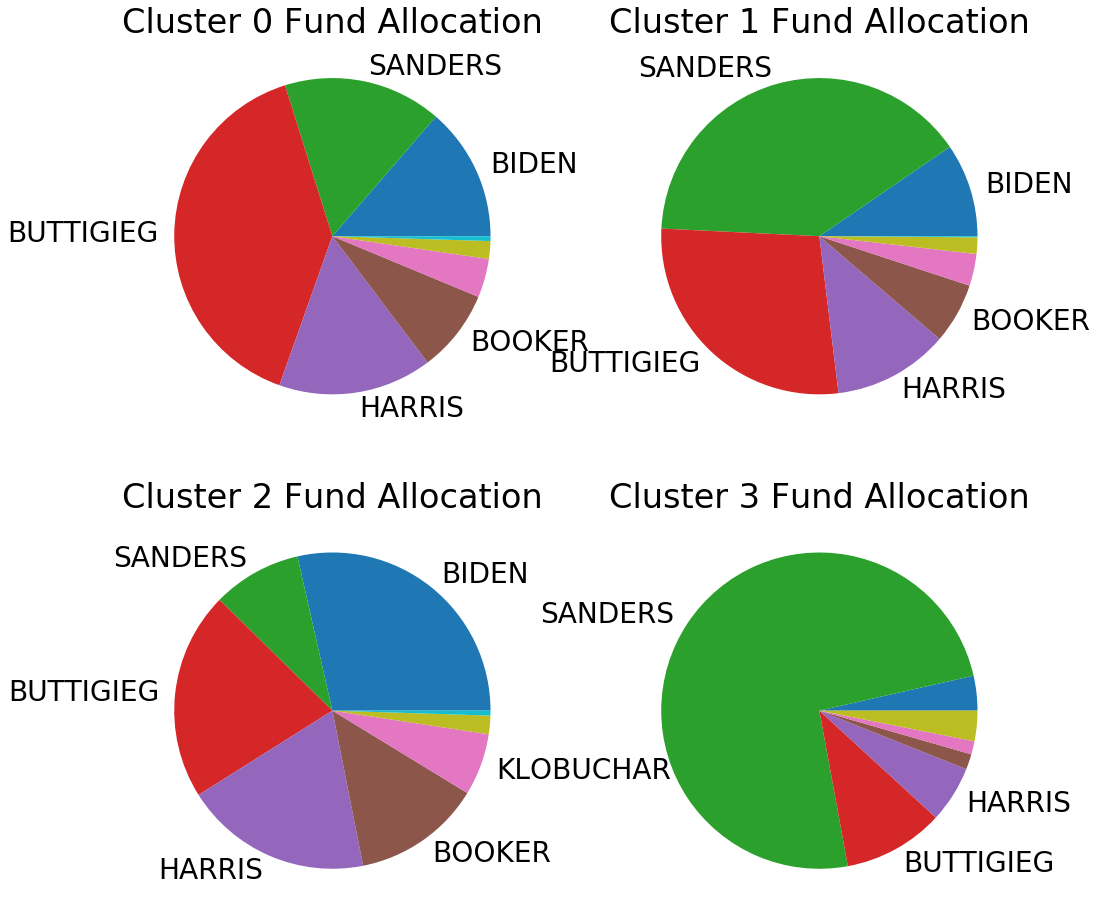

In [150]:
result = cluster_jobs(temp_norm)

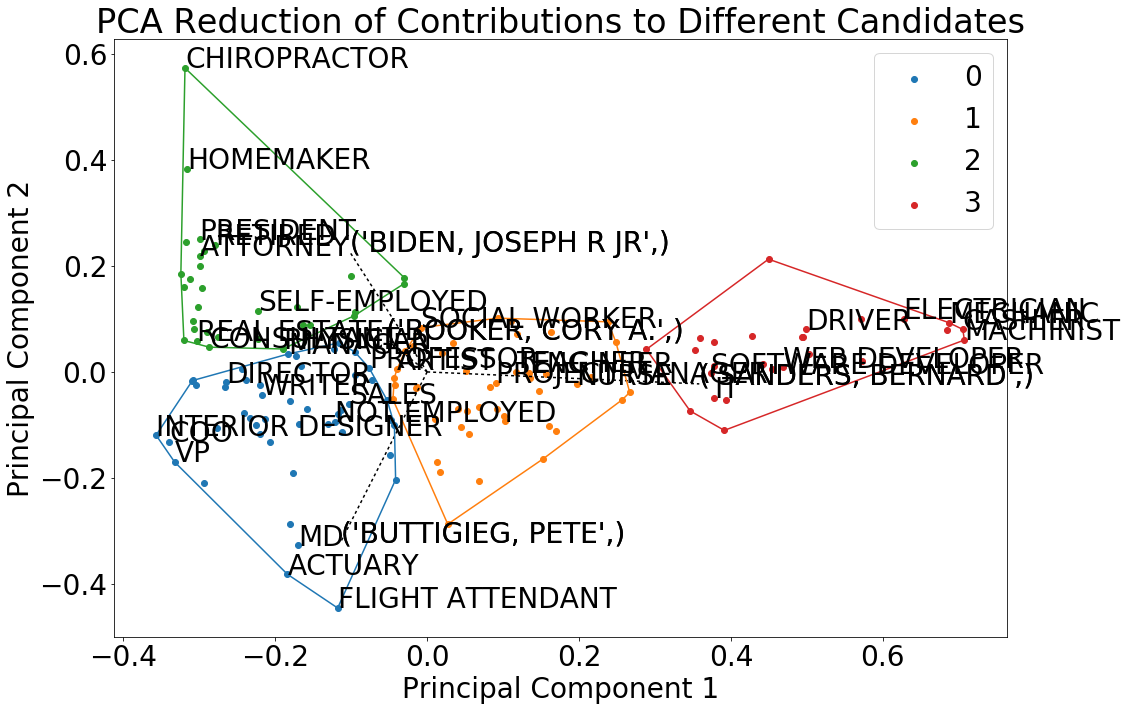

In [151]:
component_analysis(result, plot_candidate_projections=True)